In [1]:
# Import all modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dask_ml.preprocessing import Categorizer
from glum import GeneralizedLinearRegressor, TweedieDistribution
from lightgbm import LGBMRegressor
from sklearn.compose import ColumnTransformer
from sklearn.metrics import auc
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, SplineTransformer, StandardScaler
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from ps3.data import create_sample_split, load_transform

In [2]:
# load data
df = load_transform()
print(df.describe())

              IDpol        ClaimNb       Exposure       VehPower  \
count  6.780130e+05  678013.000000  678013.000000  678013.000000   
mean   2.621857e+06       0.038946       0.528545       6.255635   
std    1.641783e+06       0.205036       0.364081       1.603689   
min    1.000000e+00       0.000000       0.002732       4.000000   
25%    1.157951e+06       0.000000       0.180000       5.000000   
50%    2.272152e+06       0.000000       0.490000       6.000000   
75%    4.046274e+06       0.000000       0.990000       7.000000   
max    6.114330e+06       4.000000       1.000000       9.000000   

              VehAge        DrivAge     BonusMalus        Density  \
count  678013.000000  678013.000000  678013.000000  678013.000000   
mean        1.188850       3.782926      59.761502    1792.422405   
std         0.568775       1.304976      15.636658    3958.646564   
min         0.000000       0.000000      50.000000       1.000000   
25%         1.000000       3.000000      5

In [3]:
# Train benchmark tweedie model. This is entirely based on the glum tutorial.
weight = df["Exposure"].values
df["PurePremium"] = df["ClaimAmountCut"] / df["Exposure"]
y = df["PurePremium"]
# Print a summary of y
print(y.describe())

count    6.780130e+05
mean     3.090581e+02
std      1.806476e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+07
Name: PurePremium, dtype: float64


**Why do you think, we divide by exposure here to arrive at our outcome variable?**

We divide by the outcome variable `Exposure` as a longer exposure time makes accidents (and therefore claims) more likely. Therefore, we prefer to measure the claim amount over time than simply the total claim amount per policy.

In [9]:
# We use our create_sample_split function here to split the data into train and test
df = create_sample_split(df, 0.8)
train = np.where(df["sample"] == "train")
test = np.where(df["sample"] == "test")
df_train = df.iloc[train].copy()
df_test = df.iloc[test].copy()
print("Training Data (%): ", df_train.shape[0] / df.shape[0])
print("Test Data (%): ", df_test.shape[0] / df.shape[0])
print("Total Number of Observations: ", df.shape[0])

Training Data (%):  0.7999713869793057
Test Data (%):  0.2000286130206943
Total Number of Observations:  678013


In [10]:
# Benchmark Model
categoricals = ["VehBrand", "VehGas", "Region", "Area", "DrivAge", "VehAge", "VehPower"]

predictors = categoricals + ["BonusMalus", "Density"]
glm_categorizer = Categorizer(columns=categoricals)

X_train_t = glm_categorizer.fit_transform(df[predictors].iloc[train])
X_test_t = glm_categorizer.transform(df[predictors].iloc[test])
y_train_t, y_test_t = y.iloc[train], y.iloc[test]
w_train_t, w_test_t = weight[train], weight[test]

TweedieDist = TweedieDistribution(1.5)
t_glm1 = GeneralizedLinearRegressor(family=TweedieDist, l1_ratio=1, fit_intercept=True)
t_glm1.fit(X_train_t, y_train_t, sample_weight=w_train_t)


pd.DataFrame(
    {"coefficient": np.concatenate(([t_glm1.intercept_], t_glm1.coef_))},
    index=["intercept"] + t_glm1.feature_names_,
).T

df_test["pp_t_glm1"] = t_glm1.predict(X_test_t)
df_train["pp_t_glm1"] = t_glm1.predict(X_train_t)

print(
    "training loss t_glm1:  {}".format(
        TweedieDist.deviance(y_train_t, df_train["pp_t_glm1"], sample_weight=w_train_t)
        / np.sum(w_train_t)
    )
)

print(
    "testing loss t_glm1:  {}".format(
        TweedieDist.deviance(y_test_t, df_test["pp_t_glm1"], sample_weight=w_test_t)
        / np.sum(w_test_t)
    )
)

print(
    "Total claim amount on test set, observed = {}, predicted = {}".format(
        df["ClaimAmountCut"].values[test].sum(),
        np.sum(df["Exposure"].values[test] * t_glm1.predict(X_test_t)),
    )
)

training loss t_glm1:  73.88055076671286
testing loss t_glm1:  73.21798559441893
Total claim amount on test set, observed = 9439528.910000002, predicted = 10073636.959900279



## Let's add splines for BonusMalus and Density and use a Pipeline.
Steps: 
1. Define a Pipeline which chains a StandardScaler and SplineTransformer. Choose knots="quantile" for the SplineTransformer and make sure, we are only including one intercept in the final GLM. 

2. Put the transforms together into a ColumnTransformer. Here we use OneHotEncoder for the categoricals.

3. Chain the transforms together with the GLM in a Pipeline.

In [16]:

# Let's put together a pipeline
numeric_cols = ["BonusMalus", "Density"]
preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("scaler", StandardScaler()), ("spline", SplineTransformer(knots="quantile", include_bias=False))]), numeric_cols),
        ("cat", OneHotEncoder(sparse_output=False, drop="first"), categoricals),
    ]
)
preprocessor.set_output(transform="pandas")
model_pipeline = Pipeline(
    # Define pipeline steps here
    [
        ("preprocessor", preprocessor),
        ("estimate", GeneralizedLinearRegressor(family=TweedieDist, l1_ratio=1, fit_intercept=True)),
    ]
)

# let's have a look at the pipeline
model_pipeline

# let's check that the transforms worked
model_pipeline[:-1].fit_transform(df_train)

model_pipeline.fit(df_train, y_train_t, estimate__sample_weight=w_train_t)


/Users/benjamin/opt/anaconda3/envs/ps3/lib/python3.12/site-packages/glum/_solvers.py:58: ConvergenceWarning: Coordinate descent did not converge. You might want to increase the number of iterations. Minimum norm subgradient: 0.0007592447391917955, tolerance: 0.0001
  new_coef, gap, _, _, n_cycles = enet_coordinate_descent_gram(
/Users/benjamin/opt/anaconda3/envs/ps3/lib/python3.12/site-packages/glum/_solvers.py:58: ConvergenceWarning: Coordinate descent did not converge. You might want to increase the number of iterations. Minimum norm subgradient: 0.0005960170344941295, tolerance: 0.0001
  new_coef, gap, _, _, n_cycles = enet_coordinate_descent_gram(
/Users/benjamin/opt/anaconda3/envs/ps3/lib/python3.12/site-packages/glum/_solvers.py:58: ConvergenceWarning: Coordinate descent did not converge. You might want to increase the number of iterations. Minimum norm subgradient: 0.0004638274490985635, tolerance: 0.0001
  new_coef, gap, _, _, n_cycles = enet_coordinate_descent_gram(
/Users/ben

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('spline',
                                                                   SplineTransformer(include_bias=False,
                                                                                     knots='quantile'))]),
                                                  ['BonusMalus', 'Density']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['VehBrand', 'VehGas',
                                                   'Region', 'Area', 'DrivAge',
                                                   'VehAge', 'VehPower'])])),
                ('estimate',
                 GeneralizedLinearRegressor(family=<glum._distribution.TweedieDistribution object at 0x180b5f440>,
                                            l1_ratio=1))])

In [17]:

pd.DataFrame(
    {
        "coefficient": np.concatenate(
            ([model_pipeline[-1].intercept_], model_pipeline[-1].coef_)
        )
    },
    index=["intercept"] + model_pipeline[-1].feature_names_,
).T

df_test["pp_t_glm2"] = model_pipeline.predict(df_test)
df_train["pp_t_glm2"] = model_pipeline.predict(df_train)

print(
    "training loss t_glm2:  {}".format(
        TweedieDist.deviance(y_train_t, df_train["pp_t_glm2"], sample_weight=w_train_t)
        / np.sum(w_train_t)
    )
)

print(
    "testing loss t_glm2:  {}".format(
        TweedieDist.deviance(y_test_t, df_test["pp_t_glm2"], sample_weight=w_test_t)
        / np.sum(w_test_t)
    )
)

print(
    "Total claim amount on test set, observed = {}, predicted = {}".format(
        df["ClaimAmountCut"].values[test].sum(),
        np.sum(df["Exposure"].values[test] * df_test["pp_t_glm2"]),
    )
)


training loss t_glm2:  73.56763226401672
testing loss t_glm2:  72.76261869718482
Total claim amount on test set, observed = 9439528.910000002, predicted = 10037197.374498643


## Let's use a GBM instead as an estimator.

Steps

1. Define the modelling pipeline. Tip: This can simply be a LGBMRegressor based on X_train_t from before.

2.  Make sure we are choosing the correct objective for our estimator.

In [18]:

model_pipeline.fit(X_train_t, y_train_t, estimate__sample_weight=w_train_t)
df_test["pp_t_lgbm"] = model_pipeline.predict(X_test_t)
df_train["pp_t_lgbm"] = model_pipeline.predict(X_train_t)
print(
    "training loss t_lgbm:  {}".format(
        TweedieDist.deviance(y_train_t, df_train["pp_t_lgbm"], sample_weight=w_train_t)
        / np.sum(w_train_t)
    )
)

print(
    "testing loss t_lgbm:  {}".format(
        TweedieDist.deviance(y_test_t, df_test["pp_t_lgbm"], sample_weight=w_test_t)
        / np.sum(w_test_t)
    )
)

/Users/benjamin/opt/anaconda3/envs/ps3/lib/python3.12/site-packages/glum/_solvers.py:58: ConvergenceWarning: Coordinate descent did not converge. You might want to increase the number of iterations. Minimum norm subgradient: 0.0007592447391229285, tolerance: 0.0001
  new_coef, gap, _, _, n_cycles = enet_coordinate_descent_gram(
/Users/benjamin/opt/anaconda3/envs/ps3/lib/python3.12/site-packages/glum/_solvers.py:58: ConvergenceWarning: Coordinate descent did not converge. You might want to increase the number of iterations. Minimum norm subgradient: 0.0005960170344420245, tolerance: 0.0001
  new_coef, gap, _, _, n_cycles = enet_coordinate_descent_gram(
/Users/benjamin/opt/anaconda3/envs/ps3/lib/python3.12/site-packages/glum/_solvers.py:58: ConvergenceWarning: Coordinate descent did not converge. You might want to increase the number of iterations. Minimum norm subgradient: 0.0004638274490788411, tolerance: 0.0001
  new_coef, gap, _, _, n_cycles = enet_coordinate_descent_gram(
/Users/ben

training loss t_lgbm:  73.56763226401668
testing loss t_lgbm:  72.76261869718492


## Let's tune the LGBM to reduce overfitting.

Steps:
1. Define a `GridSearchCV` object with our lgbm pipeline/estimator. Tip: Parameters for a specific step of the pipeline can be passed by <step_name>__param. 

Note: Typically we tune many more parameters and larger grids, but to save compute time here, we focus on getting the learning rate and the number of estimators somewhat aligned -> tune learning_rate and n_estimators

In [ ]:
cv = GridSearchCV(

)
cv.fit(X_train_t, y_train_t, estimate__sample_weight=w_train_t)

df_test["pp_t_lgbm"] = cv.best_estimator_.predict(X_test_t)
df_train["pp_t_lgbm"] = cv.best_estimator_.predict(X_train_t)

print(
    "training loss t_lgbm:  {}".format(
        TweedieDist.deviance(y_train_t, df_train["pp_t_lgbm"], sample_weight=w_train_t)
        / np.sum(w_train_t)
    )
)

print(
    "testing loss t_lgbm:  {}".format(
        TweedieDist.deviance(y_test_t, df_test["pp_t_lgbm"], sample_weight=w_test_t)
        / np.sum(w_test_t)
    )
)

print(
    "Total claim amount on test set, observed = {}, predicted = {}".format(
        df["ClaimAmountCut"].values[test].sum(),
        np.sum(df["Exposure"].values[test] * df_test["pp_t_lgbm"]),
    )
)

Let's compare the sorting of the pure premium predictions

[]

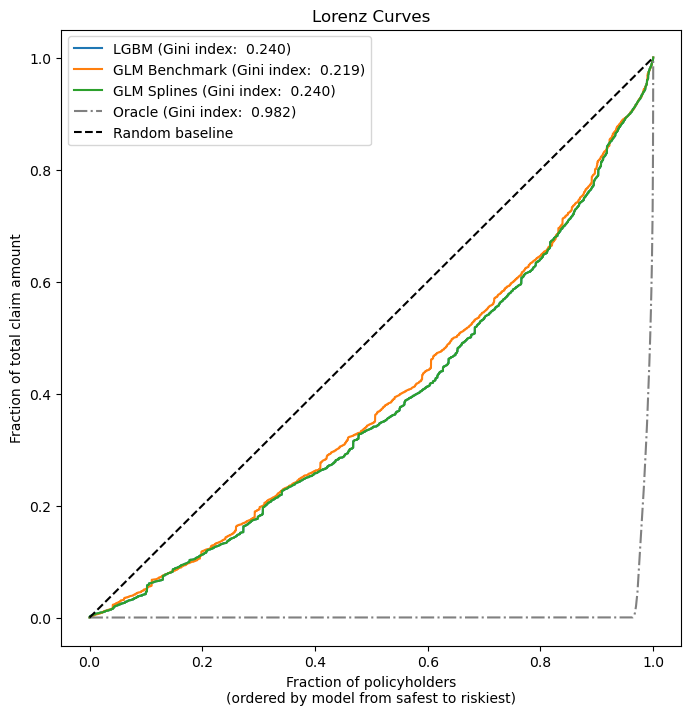

In [19]:

# Source: https://scikit-learn.org/stable/auto_examples/linear_model/plot_tweedie_regression_insurance_claims.html
def lorenz_curve(y_true, y_pred, exposure):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    exposure = np.asarray(exposure)

    # order samples by increasing predicted risk:
    ranking = np.argsort(y_pred)
    ranked_exposure = exposure[ranking]
    ranked_pure_premium = y_true[ranking]
    cumulated_claim_amount = np.cumsum(ranked_pure_premium * ranked_exposure)
    cumulated_claim_amount /= cumulated_claim_amount[-1]
    cumulated_samples = np.linspace(0, 1, len(cumulated_claim_amount))
    return cumulated_samples, cumulated_claim_amount


fig, ax = plt.subplots(figsize=(8, 8))

for label, y_pred in [
    ("LGBM", df_test["pp_t_lgbm"]),
    ("GLM Benchmark", df_test["pp_t_glm1"]),
    ("GLM Splines", df_test["pp_t_glm2"]),
]:
    ordered_samples, cum_claims = lorenz_curve(
        df_test["PurePremium"], y_pred, df_test["Exposure"]
    )
    gini = 1 - 2 * auc(ordered_samples, cum_claims)
    label += f" (Gini index: {gini: .3f})"
    ax.plot(ordered_samples, cum_claims, linestyle="-", label=label)

# Oracle model: y_pred == y_test
ordered_samples, cum_claims = lorenz_curve(
    df_test["PurePremium"], df_test["PurePremium"], df_test["Exposure"]
)
gini = 1 - 2 * auc(ordered_samples, cum_claims)
label = f"Oracle (Gini index: {gini: .3f})"
ax.plot(ordered_samples, cum_claims, linestyle="-.", color="gray", label=label)

# Random baseline
ax.plot([0, 1], [0, 1], linestyle="--", color="black", label="Random baseline")
ax.set(
    title="Lorenz Curves",
    xlabel="Fraction of policyholders\n(ordered by model from safest to riskiest)",
    ylabel="Fraction of total claim amount",
)
ax.legend(loc="upper left")
plt.plot()

# %%